# Gaussian Mixture Model REBAR implementation.

In [6]:
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
def generate_gmm_data(means: torch.Tensor,
                      cov_matrices: torch.Tensor,
                      class_weights: torch.Tensor,
                      n_samples: int,
                      random_state: int | None = None
                      ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    means: to co oznaczamy jako mu (b na tablicy)
    cov_matrices: to co oznaczamy jako A

    Returns: x, y
    """
    if random_state is not None:
        torch.manual_seed(random_state)

    dim = means.shape[-1]
    n_classes = means.shape[0]

    classes = torch.tensor(list(range(n_classes)))
    y_indices = torch.multinomial(class_weights, n_samples, replacement=True)
    y = classes[y_indices]
    x = torch.zeros((n_samples, dim))

    for c in range(n_classes):
        n_samples_for_class = torch.sum(y == c).item()
        # zeta ~ N(0, I)
        zeta = torch.randn(n_samples_for_class, dim)
        # X = A * Zeta + b
        a_zeta = torch.matmul(cov_matrices[c], zeta.T).T
        x[y == c] = a_zeta + means[c]

    return x, y

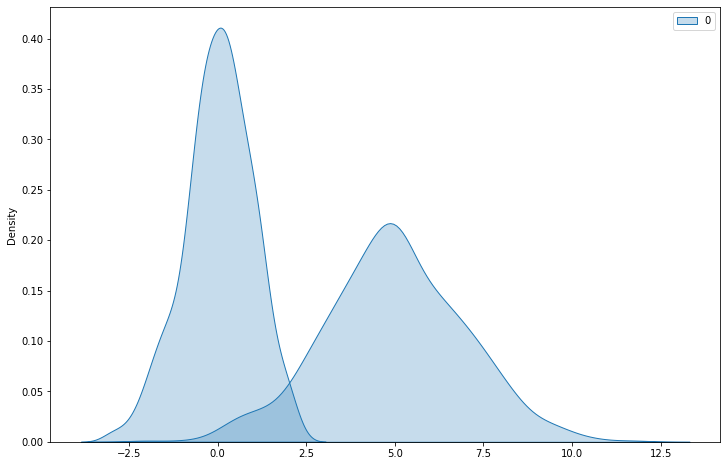

In [3]:
means = torch.tensor([
    [0], 
    [5]
], dtype=torch.float32)

cov_matrices = torch.tensor([
    [[1]], 
    [[2]]
], dtype=torch.float32)

x, y = generate_gmm_data(
    means,
    cov_matrices,
    class_weights=torch.tensor([0.3, 0.7]),
    n_samples=1000, 
    random_state=28,
)

x0 = x[y == 0]
x1 = x[y == 1]

fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.kdeplot(x0, ax = ax, fill = True, color = 'red')
sns.kdeplot(x1, ax = ax, fill = True, color = 'blue')
plt.show()

# REBAR

## Component definitions

In [4]:
normal = torch.distributions.Normal(0, 1)

In [8]:
def H(z):
    """
    Hard threshold, maps z to classes
    """
    return torch.where(z >= 0, 1, 0)

In [9]:
def sigmoid(z, temp=0.1):
    """
    Soft threshold with temperature
    """
    return torch.sigmoid(z / temp)

## `get_z(...)` $\rightarrow z$

### $z = \Phi^{-1}(u) + \theta$

In [10]:
def get_z(u, theta):
    """
    Obtains z using normal distribution

    Arguments:
        u: is a quantile of normal distribution, should come from uniform on [0, 1]
        theta: rebar parameter
    """
    return normal.icdf(u) + theta

## `get_z_alt(...)` $\rightarrow \widetilde{z}$

### $\widetilde{z} = -y\Phi^{-1}(v\cdot\Phi(y\theta)) + \theta$

where:

$y = 2 \cdot H(z) - 1$

$H(z) = 0 \quad \longrightarrow \quad 
y=-1 \quad \longrightarrow \quad 
\widetilde{z} = \Phi^{-1}(v\cdot\Phi(-\theta)) + \theta$

$H(z) = 1 \quad \longrightarrow \quad 
y=+1 \quad \longrightarrow \quad 
\widetilde{z} = -\Phi^{-1}(v\cdot\Phi(\theta)) + \theta$

In [12]:
def get_z_alt(v, h_z, theta):
    """
    Obtains z~ using v, H(z), and theta

    z~ is a differential reparametrisation of z|c
    """
    # H(z) = 0 -> y = -1
    # H(z) = 1 -> y = 1
    y = 2 * h_z - 1
    return -y * normal.icdf(v * normal.cdf(y * theta)) + theta

In [13]:
def f(x: torch.Tensor, condition, means, cov_matrices):
    """
    p(x|condition)
    f z papera
    (na razie przypadek binarny)
    to rebar maksymalizuje
    """

    def pdf_for_class(inp: torch.Tensor, c: int):
        """Gaussian distribution density for class c"""
        dist = torch.distributions.MultivariateNormal(
            means[c],
            cov_matrices[c],
        )
        return dist.log_prob(inp).exp()
    
    condition_expanded = condition.unsqueeze(0)
    # if we want to calculate for the whole batch of x's
    if x.dim() != 1:
        prob_0 = (1 - condition_expanded) * pdf_for_class(x, 0).unsqueeze(1)
        prob_1 = condition_expanded * pdf_for_class(x, 1).unsqueeze(1)
        prob = prob_0 + prob_1
    # if we want to calculate for a single value of x
    else:
        prob_0 = (1 - condition_expanded) * pdf_for_class(x, 0)
        prob_1 = condition_expanded * pdf_for_class(x, 1)
        prob = prob_0 + prob_1

    return prob

# Experiments

In [14]:
from abc import ABC, abstractmethod

In [15]:
class GMMEstimatorSGD(ABC):
    """
    Estimator for GMM using SGD
    """

    def __init__(self, n_classes: int):
        self.n_classes = n_classes
        self.theta = None
        self.means = None
        self.cov_matrices = None

    def set_default_params_(self, x=None, theta=None, means=None, cov_matrices=None):
        if theta is not None:
            self.theta = theta
        else:
            self.theta = torch.tensor(0.)

        if means is not None:
            self.means = means
        elif x is not None:
            # randomly sample n_classes from x and assign these as initial means
            self.means = x[torch.randperm(x.size(0))[:self.n_classes]]

        if cov_matrices is not None:
            self.cov_matrices = cov_matrices
        elif x is not None:
            dim = x.shape[-1]
            self.cov_matrices = torch.stack([
                torch.eye(dim, dtype=torch.float32) for _ in range(self.n_classes)
            ])

    @property
    def estimated_class_weights(self) -> torch.Tensor:
        """
        Return estimated class weights for GMM
        """
        # for now only binary case
        # print(self.theta)
        prob_1 = normal.cdf(-self.theta)
        return torch.tensor([1 - prob_1, prob_1])
    
    def calc_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        # print(self.estimated_class_weights[1], self.means, self.cov_matrices)
        return f(x, self.estimated_class_weights[1], self.means, self.cov_matrices).mean(0)[0]

    def fit(self,
            x: torch.Tensor,
            n_iter: int,
            sample_size: int = 100,
            init_lr: float = 1e-1,
            lr_decay_factor: float = 1.0,
            temperature: float = 1.0,
            ) -> dict[str, list]:
        """
        Use REBAR with SGD to estimate theta, means and cov_matrices

        Learning rate decays exponentially in each iteration according to the following formula:
            lr = init_lr * (lr_decay_factor ** i)
        where i is the number of iterations starting from 0. 
        Default lr_decay_factor is 1.0 which means a constant learning rate.

        Returns a dict with history of likelihood values, thetas, estimated class weights,
        estimated means and estimated covariance matrices
        """
        print('')  # without this print tqdm fails to show up

        # if any of self.theta self.means self.cov_matrices is None it will
        # have a default value assigned otherwise it will be left intact
        self.set_default_params_(x, self.theta, self.means, self.cov_matrices)

        history = {
            'likelihood': [],
            'theta': [],
            'class_weights': [],
            'means': [],
            'cov_matrices': [],
        }

        # SGD
        for i in tqdm(range(n_iter)):

            theta_grad, means_grad, cov_matrices_grad = self.estimate_grad(
                x, sample_size=sample_size, temperature=temperature
            )
            # decay lr
            lr = init_lr * (lr_decay_factor ** i)

            # gradient descent
            self.theta += lr * theta_grad
            self.means += lr * means_grad
            self.cov_matrices += lr * cov_matrices_grad

            # update history
            history['likelihood'].append(self.calc_likelihood(x))
            history['theta'].append(self.theta)
            history['class_weights'].append(self.estimated_class_weights)
            history['means'] += [self.means.clone().detach().numpy()]
            history['cov_matrices'] += [self.cov_matrices.clone().detach().numpy()]

        return history

    @abstractmethod
    def estimate_grad(self, x: torch.Tensor, sample_size: int, temperature: float):
        """
        Estimate gradient of p

        Arguments:
            x: input data (one observation)
            sample_size: how many u and v to generate
            temperature: softening temperature (passed as temp to softmax())

        Returns:
            theta_grad, means_grad, cov_grad
        """
        raise NotImplementedError

In [16]:
class REBAR(GMMEstimatorSGD):
    """
    REBAR for GMM
    """
    def estimate_grad(self, x: torch.Tensor, sample_size: int, temperature: float):
        """
        Estimate gradient of p using REBAR.

        Arguments:
            x: input data (one observation)
            sample_size: how many u and v to generate
            temperature: softening temperature (passed as temp to softmax())

        Returns:
            theta_grad, means_grad, cov_grad
        """
        u = torch.rand(sample_size)
        v = torch.rand(sample_size)

        z = get_z(u, self.theta)
        # z_alt = z~
        z_alt = get_z_alt(v, H(z), self.theta)
        y = 1 - 2 * H(z)  # y = -1/+1

        ### CALCULATE GRADIENT FOR THETA

        # dlogp -> d log(p(c|theta))
        dlogp = torch.func.grad(
            lambda theta_: normal.cdf(-theta_).log().sum()
        )(y * self.theta) * y

        # b:    f(H(z))         p(x|c(z))     
        # sb:   nf(sigma(z~))   p(x|sigm(z~))
        # ds:   nf'(sigma(z))   dp(x|sigm(z))
        # dsb   nf'(sigma(z~))  dp(x|sigm(z~))
        # TODO: dac lepsze oznaczenia
        eps = 1e-8
        tmp_thetas = self.theta.clone().detach().requires_grad_(True)
        b = f(x, H(z), self.means, self.cov_matrices).mean(1)

        sb = f(x, sigmoid(z_alt, temperature), self.means, self.cov_matrices).mean(1)
        
        def get_vjp_for_ds(batch):
            return torch.autograd.grad(
                f(x, sigmoid(get_z(u, tmp_thetas), temperature), self.means, self.cov_matrices).mean(1), tmp_thetas, batch) # mean(1) means taking the mean over u,v sampling
        ds = torch.vmap(get_vjp_for_ds)(torch.eye(x.shape[0]))[0]
        denominator = f(x, H(z), self.means, self.cov_matrices).mean(1)

        def get_vjp_for_dsb(batch):
                    return torch.autograd.grad(
                        f(
                x, sigmoid(get_z_alt(v, H(z), tmp_thetas), temperature), self.means, self.cov_matrices).mean(1), tmp_thetas, batch) # mean(1) means taking the mean over u,v sampling
        
        dsb = torch.vmap(get_vjp_for_dsb)(torch.eye(x.shape[0]))[0]
        
        theta_grad = ((ds - dsb + ((b - sb) * dlogp).mean(0))/(1000*denominator.clip(eps))).mean(0)

        ### CALCULATE GRADIENT FOR MEANS AND COV_MATRICES
        # we need these to have requires_grad to be able to use autograd
        tmp_means = self.means.clone().detach().requires_grad_(True)
        tmp_cov_matrices = self.cov_matrices.clone().detach().requires_grad_(True)
        denominator = denominator[:,None,None]
        def get_vjp_over_means(batch):
            return torch.autograd.grad(
                f(x, H(z), tmp_means, self.cov_matrices).mean(1), tmp_means, batch
            ) # mean(1) means taking the mean over u,v sampling
        numerator_means = torch.vmap(get_vjp_over_means)(torch.eye(x.shape[0]))[0]
        # 

        def get_vjp_over_covs(batch):
            return torch.autograd.grad(
                f(x, H(z), self.means, tmp_cov_matrices).mean(1), tmp_cov_matrices, batch
            )
        numerator_covs = torch.vmap(get_vjp_over_covs)(torch.eye(x.shape[0]))[0]

        # mean(0) means taking the mean over samples in x
        means_grad = (numerator_means / denominator.clip(eps)).mean(0) 
        
        denominator = denominator[:,:,:,None]
        cov_grad = (numerator_covs / denominator.clip(eps)).mean(0)
        # print('grads:', theta_grad, means_grad, cov_grad)
        return theta_grad, means_grad, cov_grad

In [17]:
class REINFORCE(GMMEstimatorSGD):
    """
    REINFORCE for GMM
    """
    def estimate_grad(self, x: torch.Tensor, sample_size: int, temperature: float):
        """
        Estimate gradient of p using REBAR.

        Arguments:
            x: input data (one observation)
            sample_size: how many u and v to generate
            temperature: softening temperature (passed as temp to softmax())

        Returns:
            theta_grad, means_grad, cov_grad
        """
        u = torch.rand(sample_size)
        z = get_z(u, self.theta)

        ### CALCULATE GRADIENT FOR THETA

        # b:    f(H(z))         p(x|c(z))     
        # sb:   nf(sigma(z~))   p(x|sigm(z~))
        # ds:   nf'(sigma(z))   dp(x|sigm(z))
        # dsb   nf'(sigma(z~))  dp(x|sigm(z~))
        # TODO: dac lepsze oznaczenia
        eps = 1e-8
        tmp_thetas = self.theta.clone().detach().requires_grad_(True)
        b = f(x, H(z), self.means, self.cov_matrices).mean(1)
        
        def get_vjp_for_ds(batch):
            return torch.autograd.grad(
                f(x, sigmoid(get_z(u, tmp_thetas), temperature), self.means, self.cov_matrices).mean(1), tmp_thetas, batch) # mean(1) means taking the mean over u,v sampling
        ds = torch.vmap(get_vjp_for_ds)(torch.eye(x.shape[0]))[0]

        denominator = f(x, H(z), self.means, self.cov_matrices).mean(1)

        logpz = normal.log_prob(z)
        dlogpz = torch.func.grad(
            lambda theta_: normal.log_prob(get_z(u, theta_)).sum()
        )(z)

        # print(f'{ds.shape = }')
        # print(f'{b.shape = }')
        # print(f'{logpz.shape = }')
        # print(f'{dlogpz.shape = }')

        theta_grad = (((ds * logpz) + (b * dlogpz))/(1000*denominator.clip(eps))).mean(0)

        ### CALCULATE GRADIENT FOR MEANS AND COV_MATRICES
        # we need these to have requires_grad to be able to use autograd
        tmp_means = self.means.clone().detach().requires_grad_(True)
        tmp_cov_matrices = self.cov_matrices.clone().detach().requires_grad_(True)
        denominator = denominator[:,None,None]
        def get_vjp_over_means(batch):
            return torch.autograd.grad(
                f(x, H(z), tmp_means, self.cov_matrices).mean(1), tmp_means, batch
            ) # mean(1) means taking the mean over u,v sampling
        numerator_means = torch.vmap(get_vjp_over_means)(torch.eye(x.shape[0]))[0]

        def get_vjp_over_covs(batch):
            return torch.autograd.grad(
                f(x, H(z), self.means, tmp_cov_matrices).mean(1), tmp_cov_matrices, batch
            )
        numerator_covs = torch.vmap(get_vjp_over_covs)(torch.eye(x.shape[0]))[0]

        # mean(0) means taking the mean over samples in x
        means_grad = (numerator_means / denominator.clip(eps)).mean(0) 
        
        denominator = denominator[:,:,:,None]
        cov_grad = (numerator_covs / denominator.clip(eps)).mean(0)
        # print('grads:', theta_grad, means_grad, cov_grad)
        return theta_grad, means_grad, cov_grad

### Playground

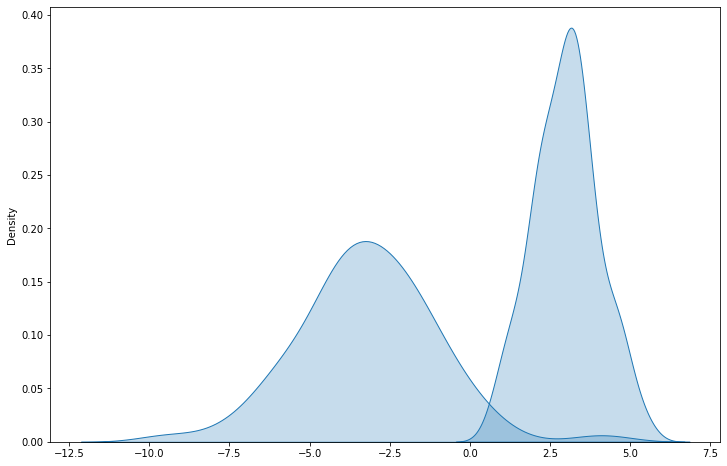

In [18]:
means = torch.tensor([
    [-3], 
    [3]
], dtype=torch.float32)

cov_matrices = torch.tensor([
    [[2]], 
    [[1]]
], dtype=torch.float32)

class_weights = torch.tensor([0.3, 0.7])

x, y = generate_gmm_data(
    means,
    cov_matrices,
    class_weights,
    n_samples=200, 
    random_state=28,
)

x0 = x[y == 0]
x1 = x[y == 1]

fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.kdeplot(x0, ax = ax, fill = True, color = 'red')
sns.kdeplot(x1, ax = ax, fill = True, color = 'blue')
ax.get_legend().remove()
plt.savefig('GaussianMixture.jpg')
plt.show()

In [19]:
rebar = REBAR(n_classes=2)
rebar.set_default_params_(
    means=torch.tensor([
        [-7.], 
        [7.]
    ])
)
history = rebar.fit(x, 100, init_lr=0.5, lr_decay_factor=0.99, sample_size=200)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:12<00:00,  7.74it/s]


In [20]:
rebar.theta

tensor(-0.4137)

In [21]:
rebar.estimated_class_weights, class_weights

(tensor([0.3396, 0.6604]), tensor([0.3000, 0.7000]))

In [22]:
rebar.means, means

(tensor([[-3.4854],
         [ 2.9532]]),
 tensor([[-3.],
         [ 3.]]))

In [23]:
rebar.cov_matrices, cov_matrices

(tensor([[[3.2042]],
 
         [[2.1666]]]),
 tensor([[[2.]],
 
         [[1.]]]))

## H(z) vs sigmoid

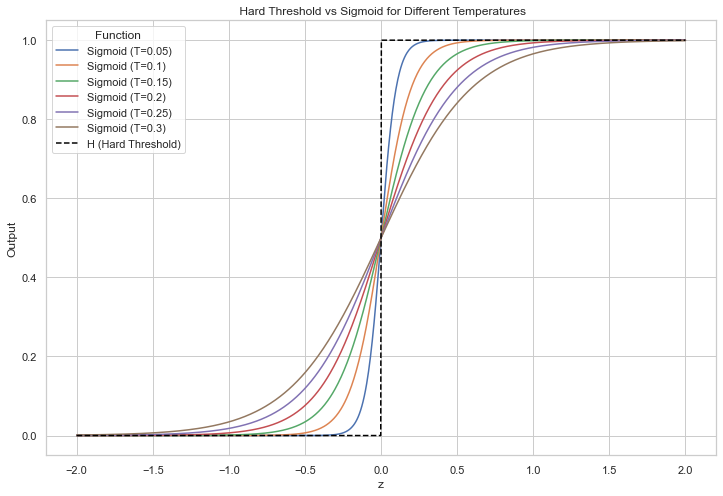

In [24]:
sample_size = 100
theta = 0.0
temperatures = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

x = torch.linspace(-2,2, 1000)
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

for temp in temperatures:
    sigmoid_values = sigmoid(x, temp=temp)
    sns.lineplot(x=x.numpy(), y=sigmoid_values.numpy(), ax=ax, label=f'Sigmoid (T={temp})')


H_values = H(x)
sns.lineplot(x=x.numpy(), y=H_values.numpy(), ax=ax, label='H (Hard Threshold)',
             linestyle='--', color='black')

ax.set_title(' Hard Threshold vs Sigmoid for Different Temperatures')
ax.set_xlabel('z')
ax.set_ylabel('Output')
ax.legend(title='Function')
plt.show()

## Comparison of likelihood between REBAR, REINFORCE and EM algorithm

In [25]:
def em_algorithm_pytorch(data, n_components, n_iter):
    means_arr = []
    # data = torch.tensor(data, dtype=torch.float32)
    
    means = torch.tensor(np.random.choice(data.numpy(), n_components), dtype=torch.float32)
    std_devs = torch.tensor(np.random.random(n_components) + 1, dtype=torch.float32)
    weights = torch.ones(n_components) / n_components
    log_likelihoods = []

    def e_step(data, means, std_devs, weights):
        responsibilities = torch.stack([weights[k] * torch.distributions.Normal(means[k], std_devs[k]).log_prob(data).exp() 
                                        for k in range(n_components)], dim=1)
        responsibilities /= responsibilities.sum(dim=1, keepdim=True)
        return responsibilities

    def m_step(data, responsibilities):
        weights = responsibilities.mean(dim=0)
        means = (data[:, None] * responsibilities).sum(dim=0) / responsibilities.sum(dim=0)
        std_devs = torch.sqrt(
            ((data[:, None] - means)**2 * responsibilities).sum(dim=0) / responsibilities.sum(dim=0))
        return means, std_devs, weights

    for _ in range(n_iter):
        responsibilities = e_step(data, means, std_devs, weights)
        means, std_devs, weights = m_step(data, responsibilities)
        means_arr.append(means)
        log_likelihood = torch.mean(torch.log(
            (responsibilities * torch.stack([torch.distributions.Normal(means[k], std_devs[k]).log_prob(data).exp() 
                                             for k in range(n_components)], dim=1)).sum(dim=1)))
        # log_likelihood =  f(data.reshape(-1, 1), responsibilities[:, 1], means.unsqueeze(1), std_devs.view(-1, 1, 1)).mean(0)[0]
        log_likelihoods.append(log_likelihood.item())

    return means, std_devs, weights, log_likelihoods, means_arr

n_components = 2
n_iter = 10
means, std_devs, weights, log_likelihoods, means_arr = em_algorithm_pytorch(x.reshape(1, -1)[0], n_components, n_iter)
print("Means:", means)
print("Standard Deviations:", std_devs)
print("Weights:", weights)
print("Likelihoods:", np.exp(log_likelihoods))

Means: tensor([ 0.9590, -0.9700])
Standard Deviations: tensor([0.6401, 0.6339])
Weights: tensor([0.5029, 0.4971])
Likelihoods: [0.31501928 0.33576684 0.35685728 0.37426814 0.38562809 0.39173468
 0.39463469 0.39592172 0.39647434 0.39670803]


100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


100%|██████████| 100/100 [00:08<00:00, 12.20it/s]


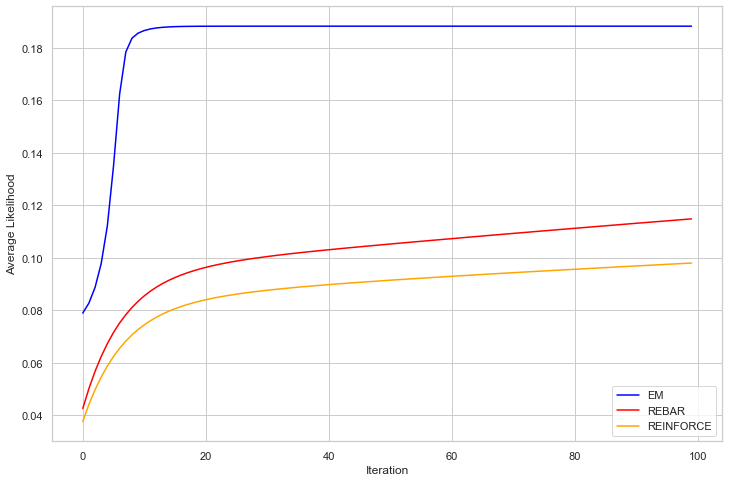

In [26]:
n_components = 2
n_iter = 100
n_samples = 200
lr = 0.5
decay = 0.99

means = torch.tensor([
    [-3], 
    [3]
], dtype=torch.float32)

cov_matrices = torch.tensor([
    [[2]], 
    [[1]]
], dtype=torch.float32)

class_weights = torch.tensor([0.3, 0.7])

x, y = generate_gmm_data(
    means,
    cov_matrices,
    class_weights,
    n_samples=200, 
    random_state=28,
)

# EM Algorithm
means_em, std_devs_em, weights_em, log_likelihoods_em, means_arr_em = em_algorithm_pytorch(
    x.reshape(1, -1)[0], n_components, n_iter
)

# REBAR Algorithm
rebar = REBAR(n_classes=2)
rebar.set_default_params_(
    means=torch.tensor([
        [-7.], 
        [7.]
    ])
)
history_rebar = rebar.fit(
    x, n_iter=n_iter, sample_size=n_samples, init_lr=lr, lr_decay_factor=decay
)
likelihoods_rebar = np.array([lik.item() for lik in history_rebar['likelihood']])

# REINFORCE Algorithm
reinforce = REINFORCE(n_classes=2)
reinforce.set_default_params_(
    means=torch.tensor([
        [-7.], 
        [7.]
    ])
)
history_reinforce = reinforce.fit(
    x, n_iter=n_iter, sample_size=n_samples, init_lr=lr, lr_decay_factor=decay
)
likelihoods_reinforce = np.array([lik.item() for lik in history_reinforce['likelihood']])


sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

plt.plot(range(n_iter), np.exp(log_likelihoods_em), label='EM', color='blue')
plt.plot(range(n_iter), likelihoods_rebar, label='REBAR', color='red')
plt.plot(range(n_iter), likelihoods_reinforce, label='REINFORCE', color='orange')

# plt.title('Average Likelihood Over Iterations for EM, REBAR, and REINFORCE')
plt.xlabel('Iteration')
plt.ylabel('Average Likelihood')
plt.legend()
plt.savefig('em_rebar_reinforce.png')
plt.show()

In [27]:
rebar.estimated_class_weights, reinforce.estimated_class_weights, class_weights

(tensor([0.3396, 0.6604]), tensor([0.4971, 0.5029]), tensor([0.3000, 0.7000]))

In [28]:
rebar.means, reinforce.means, means

(tensor([[-3.4854],
         [ 2.9532]]),
 tensor([[-3.6323],
         [ 2.8900]]),
 tensor([[-3.],
         [ 3.]]))

In [29]:
rebar.cov_matrices, reinforce.cov_matrices, cov_matrices

(tensor([[[3.2042]],
 
         [[2.1666]]]),
 tensor([[[3.0401]],
 
         [[2.3830]]]),
 tensor([[[2.]],
 
         [[1.]]]))

## Comparison of E[b] and E[H(z)]

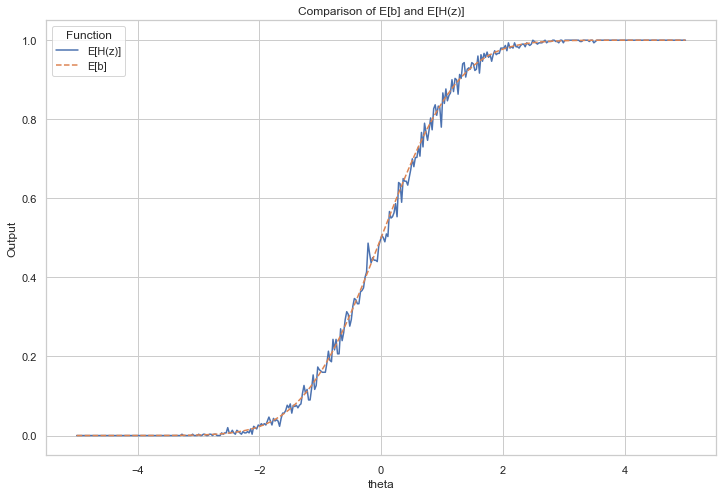

In [49]:
sample_size = 300
theta = torch.linspace(-5, 5, 400)

u = torch.rand(sample_size, theta.shape[0])
z_values = get_z(u, theta)

binary_values = H(z_values).type(torch.float32).mean(0)

cdf_values = normal.cdf(theta)

fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=theta.numpy(), y=binary_values.numpy(), ax=ax, label='E[H(z)]')
sns.lineplot(x=theta.numpy(), y=cdf_values.numpy(), ax=ax, label='E[b]', linestyle='--')

ax.set_title('Comparison of E[b] and E[H(z)]')
ax.set_xlabel('theta')
ax.set_ylabel('Output')
ax.legend(title='Function')
plt.savefig('Comparison of E[b] and E[H(z)].jpg')
plt.show()

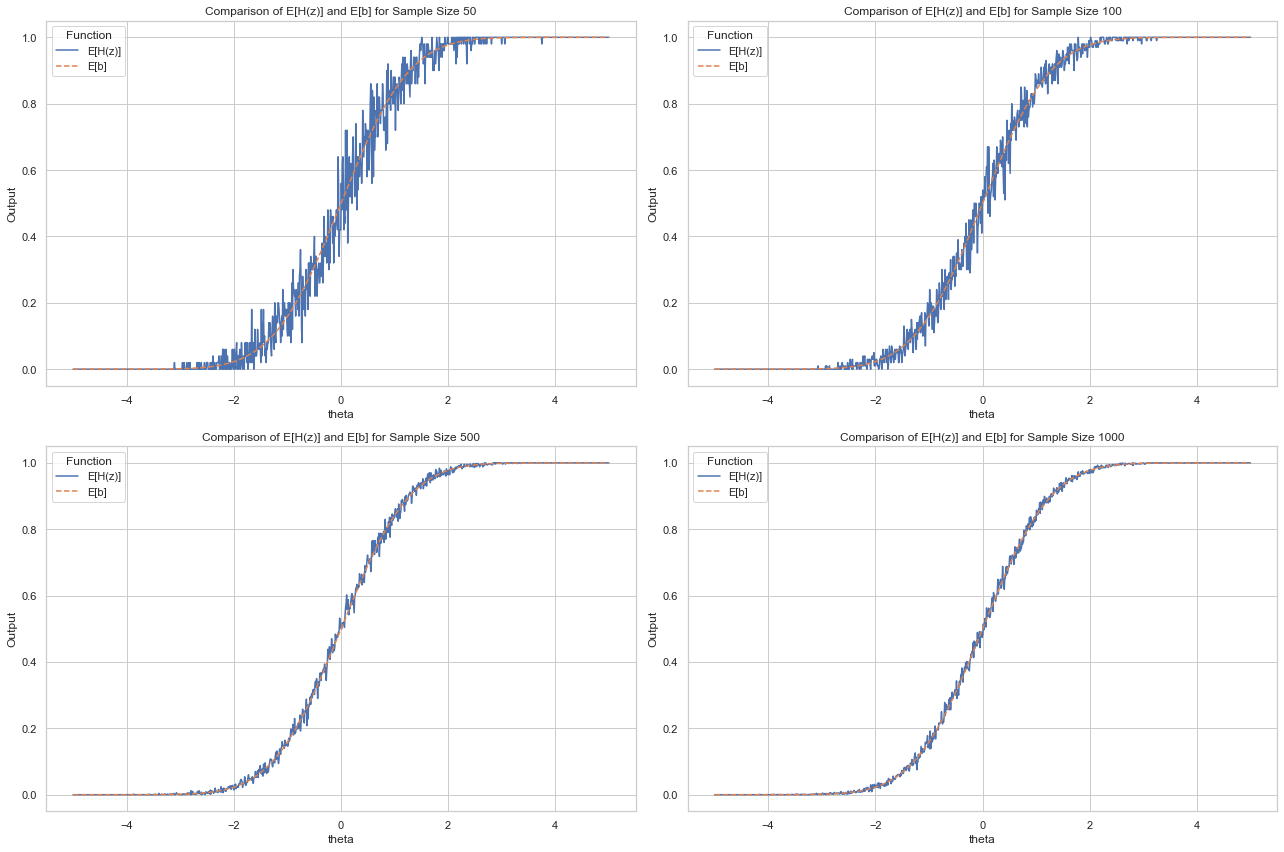

In [50]:
sample_sizes = [50, 100, 500, 1000]
theta = torch.linspace(-5, 5, 1000)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))  

for i, sample_size in enumerate(sample_sizes):
    u = torch.rand(sample_size, theta.shape[0])
    z_values = get_z(u, theta)
    binary_values = H(z_values).type(torch.float32).mean(0)
    cdf_values = normal.cdf(theta)

    row, col = divmod(i, 2) 
    sns.lineplot(x=theta.numpy(), y=binary_values.numpy(), ax=axes[row, col], label='E[H(z)]')
    sns.lineplot(x=theta.numpy(), y=cdf_values, ax=axes[row, col], label='E[b]', linestyle='--')

    axes[row, col].set_title(f'Comparison of E[H(z)] and E[b] for Sample Size {sample_size}')
    axes[row, col].set_xlabel('theta')
    axes[row, col].set_ylabel('Output')
    axes[row, col].legend(title='Function')

plt.tight_layout()
plt.show()

## Comparison of E[b] and E[sigmoid(z)]

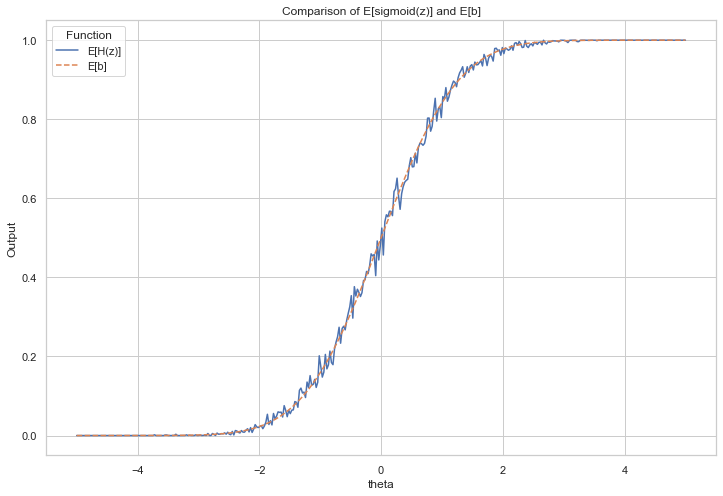

In [51]:
sample_size = 300
theta = torch.linspace(-5, 5, 400)

u = torch.rand(sample_size, theta.shape[0])
z_values = get_z(u, theta)
binary_values = sigmoid(z_values, 0.1).type(torch.float32).mean(0)
cdf_values = normal.cdf(theta)

fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=theta.numpy(), y=binary_values.numpy(), ax=ax, label='E[H(z)]')
sns.lineplot(x=theta.numpy(), y=cdf_values.numpy(), ax=ax, label='E[b]', linestyle='--')

ax.set_title('Comparison of E[sigmoid(z)] and E[b]')
ax.set_xlabel('theta')
ax.set_ylabel('Output')
ax.legend(title='Function')
plt.savefig('Comparison of E[sigmoid(z)] and E[H(z)].jpg')
plt.show()

## We don't need to use sigmoid, softization here is not needed to estimate expected value 

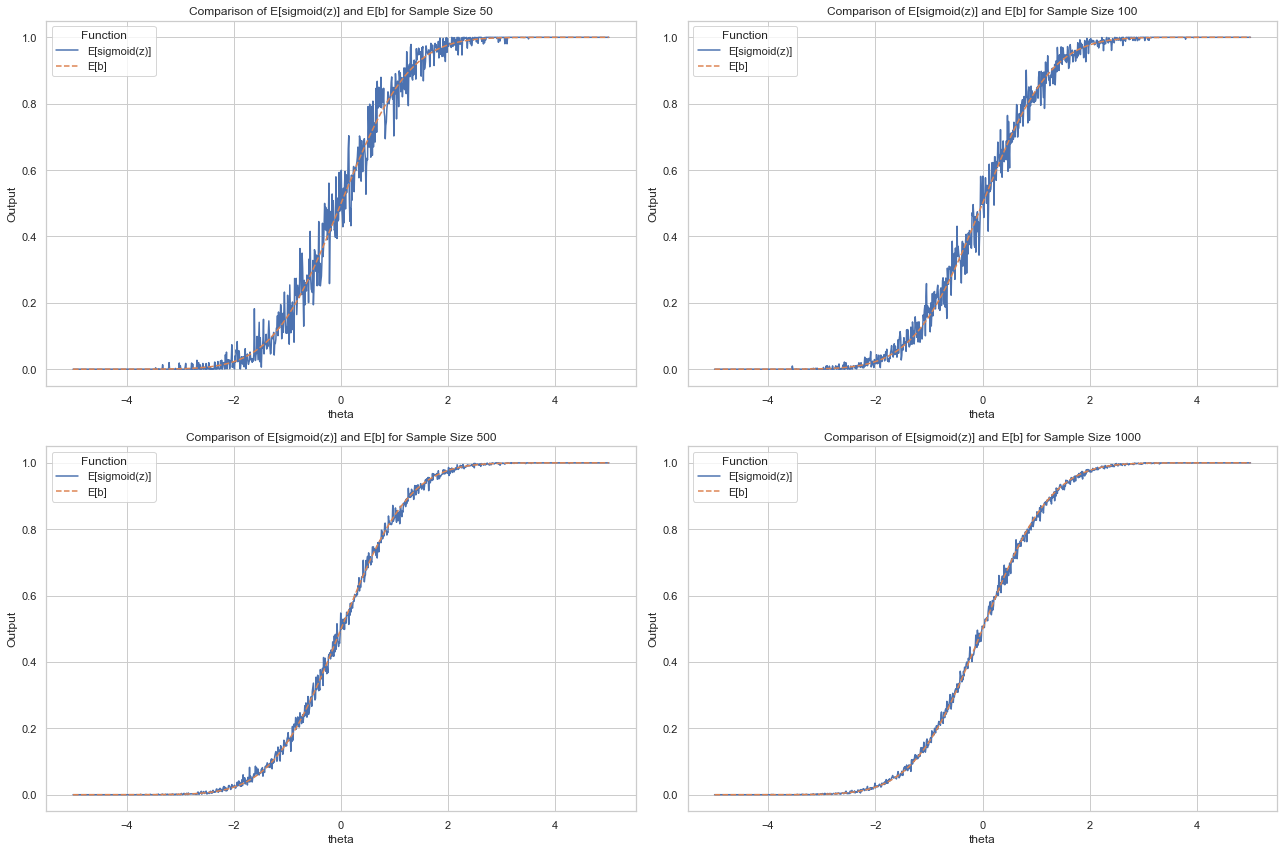

In [52]:
sample_sizes = [50, 100, 500, 1000]
theta = torch.linspace(-5, 5, 1000)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))  

for i, sample_size in enumerate(sample_sizes):
    u = torch.rand(sample_size, theta.shape[0])
    z_values = get_z(u, theta)
    binary_values = sigmoid(z_values, 0.1).type(torch.float32).mean(0)
    cdf_values = normal.cdf(theta)

    row, col = divmod(i, 2) 
    sns.lineplot(x=theta.numpy(), y=binary_values.numpy(), ax=axes[row, col], label='E[sigmoid(z)]')
    sns.lineplot(x=theta.numpy(), y=cdf_values, ax=axes[row, col], label='E[b]', linestyle='--')

    axes[row, col].set_title(f'Comparison of E[sigmoid(z)] and E[b] for Sample Size {sample_size}')
    axes[row, col].set_xlabel('theta')
    axes[row, col].set_ylabel('Output')
    axes[row, col].legend(title='Function')

plt.tight_layout()
plt.show()

## But we DO need softization when estimating the gradient

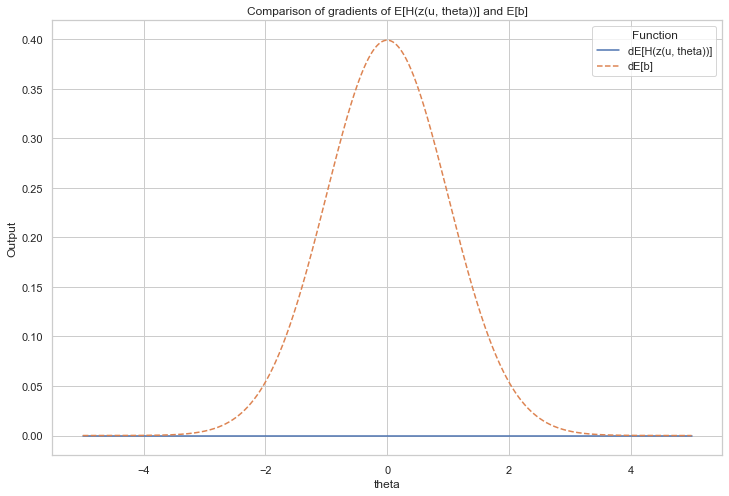

In [54]:
sample_size = 300
theta = torch.linspace(-5, 5, 1000)

u = torch.rand(sample_size, theta.shape[0])
z_values = get_z(u, theta)

grad = torch.func.grad(lambda theta_: H(get_z(u, theta_)).type(torch.float32).mean(0).sum())(theta)
# mean po u samplowych

pdf_values = normal.log_prob(theta).exp()

fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=theta.numpy(), y=grad.numpy(), ax=ax, label='dE[H(z(u, theta))]')
sns.lineplot(x=theta.numpy(), y=pdf_values.numpy(), ax=ax, label='dE[b]', linestyle='--')

ax.set_title('Comparison of gradients of E[H(z(u, theta))] and E[b]')
ax.set_xlabel('theta')
ax.set_ylabel('Output')
ax.legend(title='Function')
plt.savefig('Comparison of gradients of E[H(z(u, theta))] and E[b]')
plt.show()

### Conclusion: it is impossible to estimate the derivative without softization. 
                                                                
## And what does it look like with softization?

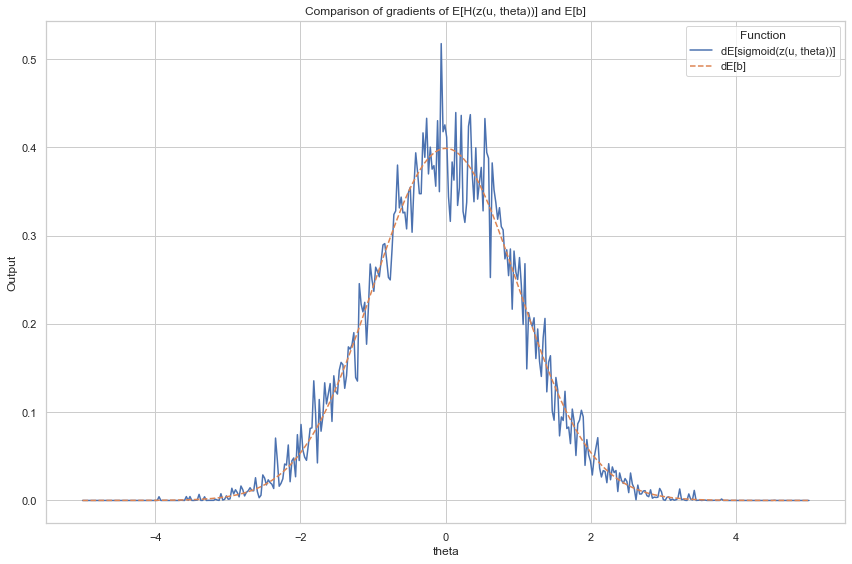

In [55]:
sample_size = 300
theta = torch.linspace(-5, 5, 400)
temp = 0.1


u = torch.rand(sample_size, theta.shape[0])

grad = torch.autograd.functional.jacobian(lambda theta_: sigmoid(get_z(u, theta_), temp).mean(0).sum(), theta)
pdf_values = normal.log_prob(theta).exp()
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=theta.numpy(), y=grad.numpy(), ax=ax, label='dE[sigmoid(z(u, theta))]')
sns.lineplot(x=theta.numpy(), y=pdf_values, ax=ax, label='dE[b]', linestyle='--')

ax.set_title(f'Comparison of gradients of E[H(z(u, theta))] and E[b]')
ax.set_xlabel('theta')
ax.set_ylabel('Output')
ax.legend(title='Function')

plt.tight_layout()
plt.show()

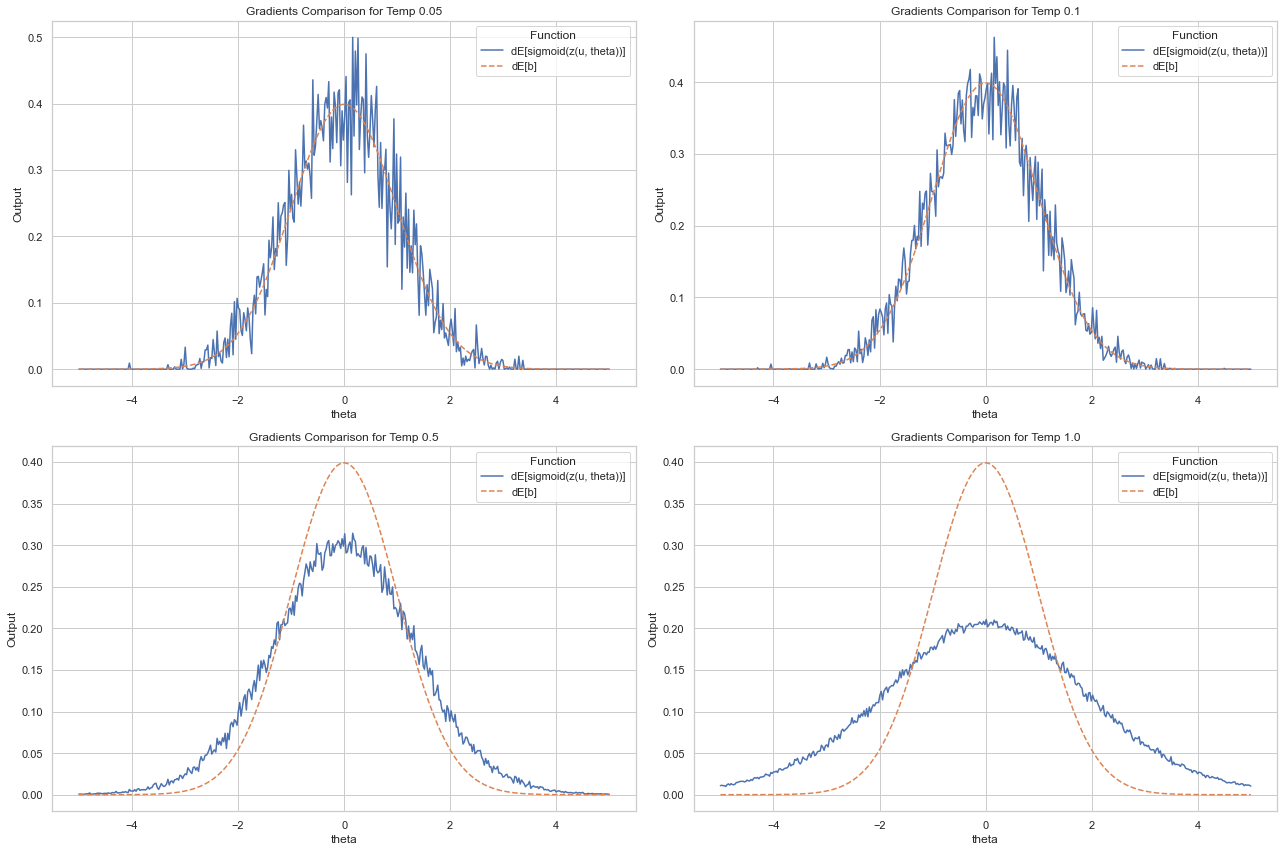

In [56]:
sample_size = 300
theta = torch.linspace(-5, 5, 400)
temperatures = [0.05, 0.1, 0.5, 1.0]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

u = torch.rand(sample_size, theta.shape[0])

for i, temp in enumerate(temperatures):
    grad = torch.autograd.functional.jacobian(lambda theta_: sigmoid(get_z(u, theta_), temp).mean(0).sum(), theta)
    pdf_values = normal.log_prob(theta).exp()

    row, col = divmod(i, 2)
    sns.lineplot(x=theta.numpy(), y=grad.numpy(), ax=axes[row, col], label='dE[sigmoid(z(u, theta))]')
    sns.lineplot(x=theta.numpy(), y=pdf_values, ax=axes[row, col], label='dE[b]', linestyle='--')

    axes[row, col].set_title(f'Gradients Comparison for Temp {temp}')
    axes[row, col].set_xlabel('theta')
    axes[row, col].set_ylabel('Output')
    axes[row, col].legend(title='Function')

plt.tight_layout()
plt.savefig('Comparison of E[sigmoid(z)] with Different Temperatures ')
plt.show()

### Now we can see that when we use softmatization, the higher the temperature (degree of relaxation of the discrete model), the lower the variance, but bias increases. 
### On the other hand, temperatures close to zero have nearly no bias, but they diverge in variance.

In [57]:
def rebar_simple(theta, sample_size=100, temp=1.0):
    u = torch.rand(sample_size, theta.shape[0])
    v = torch.rand(sample_size, theta.shape[0])
    
    z = get_z(u, theta)
    # z_alt = z~
    z_alt = get_z_alt(v, H(z), theta)
    y = 1 - 2 * H(z)

    dlogp = torch.func.grad(
            lambda theta_: normal.cdf(-theta_).log().sum()
        )(y * theta)
    
    b = H(z)

    sb = sigmoid(z_alt, temp)

    ds = torch.func.grad(
        lambda theta_: sigmoid(get_z(u, theta_), temp).mean(0).sum()
    )(theta)

    dsb = torch.func.grad(
        lambda theta_: sigmoid(get_z_alt(v, H(z), theta_), temp).mean(0).sum()
    )(theta)

    # w paperze
    # b:    f(H(z))
    # sb:   nf(sigma(z~))
    # ds:   nf'(sigma(z))
    # dsb   nf'(sigma(z~))
        
    return ds - dsb + ((b - sb) * dlogp).mean(0)

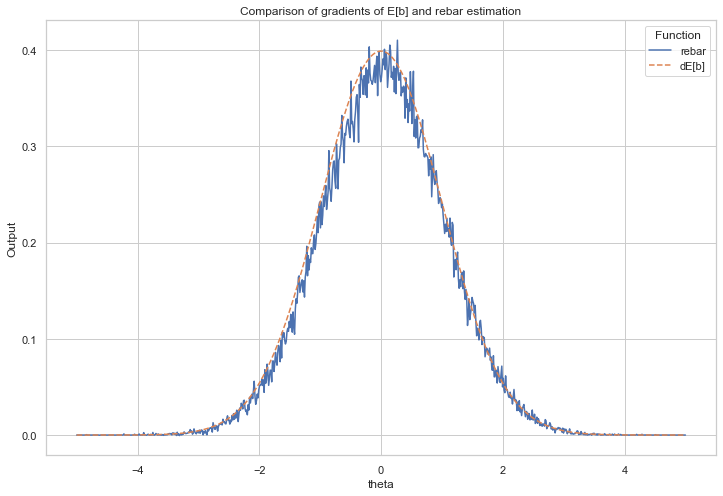

In [58]:
sample_size = 5000
theta = torch.linspace(-5, 5, 800)

u = torch.rand(sample_size, theta.shape[0])
z_values = get_z(u, theta)

grad = rebar_simple(theta, sample_size=sample_size, temp=0.04)

pdf_values = normal.log_prob(theta).exp()

fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=theta.numpy(), y=grad.numpy(), ax=ax, label='rebar')
sns.lineplot(x=theta.numpy(), y=pdf_values.numpy(), ax=ax, label='dE[b]', linestyle='--')

ax.set_title('Comparison of gradients of E[b] and rebar estimation')
ax.set_xlabel('theta')
ax.set_ylabel('Output')
ax.legend(title='Function')
plt.savefig('Comparison of gradients of E[b] and rebar estimation')
plt.show()

Comparison

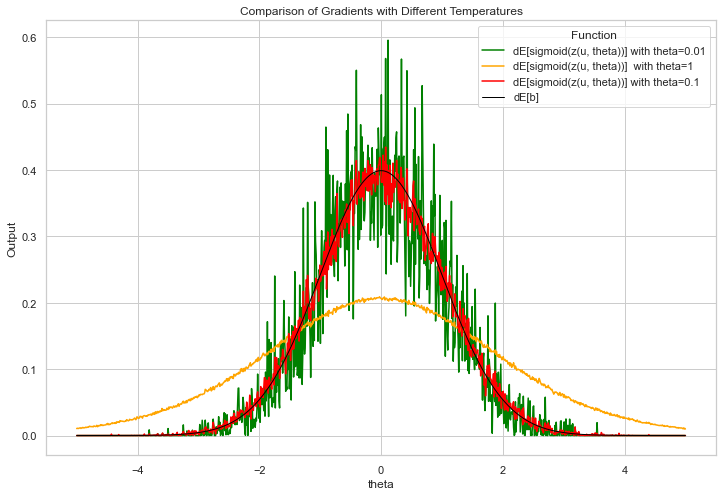

In [61]:
sample_size = 1000
theta = torch.linspace(-5, 5, 1000)

u = torch.rand(sample_size, theta.shape[0])
z_values = get_z(u, theta)

# grad = rebar_simple(theta, sample_size=sample_size, temp=0.01)
grad_soft_0_01 = torch.autograd.functional.jacobian(
    lambda theta_: sigmoid(get_z(u, theta_), temp=0.01).mean(0).sum(), theta)
grad_soft_0_1 = torch.autograd.functional.jacobian(
    lambda theta_: sigmoid(get_z(u, theta_), temp=0.1).mean(0).sum(), theta)
grad_soft_1 = torch.autograd.functional.jacobian(
    lambda theta_: sigmoid(get_z(u, theta_), temp=1).mean(0).sum(), theta)


pdf_values = normal.log_prob(theta).exp()

fig, ax = plt.subplots(figsize=(12, 8))


sns.lineplot(x=theta.numpy(), y=grad_soft_0_01.numpy(), ax=ax, label='dE[sigmoid(z(u, theta))] with theta=0.01', color = 'green')
sns.lineplot(x=theta.numpy(), y=grad_soft_1.numpy(), ax=ax, label='dE[sigmoid(z(u, theta))]  with theta=1', color = 'orange')
sns.lineplot(x=theta.numpy(), y=grad_soft_0_1.numpy(), ax=ax, label='dE[sigmoid(z(u, theta))] with theta=0.1', color = 'red')
sns.lineplot(x=theta.numpy(), y=pdf_values.numpy(), ax=ax, label='dE[b]', color = 'black', linewidth = 1)


##sns.lineplot(x=theta.numpy(), y=grad.numpy(), ax=ax, label='rebar', color='red')


ax.set_title('Comparison of Gradients with Different Temperatures')
ax.set_xlabel('theta')
ax.set_ylabel('Output')
ax.legend(title='Function')
plt.savefig('Comparison of dE[sigmoid(z)] with Different Temperatures')
plt.show()

100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


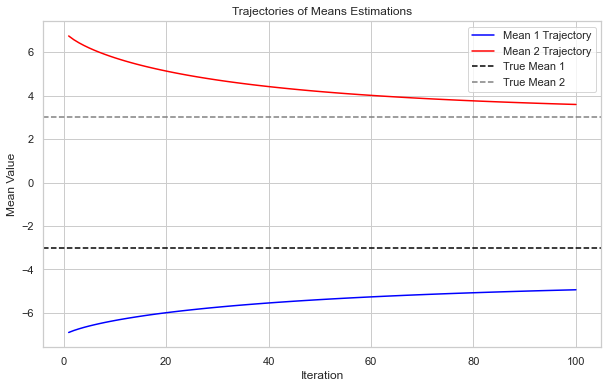

In [64]:
means = torch.tensor([[-3], [3]], dtype=torch.float32)
cov_matrices = torch.tensor([[[2]], [[1]]], dtype=torch.float32)
class_weights = torch.tensor([0.3, 0.7])
x, y = generate_gmm_data(means, cov_matrices, class_weights, n_samples=200, random_state=28)

# Creating REBAR instance and fitting the model
rebar = REBAR(n_classes=2)
rebar.set_default_params_(means=torch.tensor([[-7.], [7.]]))
history = rebar.fit(x, 100, init_lr=1e-1, lr_decay_factor=0.99, sample_size=200)

# Plotting trajectories of means estimations
iterations = np.arange(1, 101)
mean_1 = np.array([h[0][0] for h in history['means']])
mean_2 = np.array([h[1][0] for h in history['means']])

plt.figure(figsize=(10, 6))
plt.plot(iterations, mean_1, label='Mean 1 Trajectory', color='blue')
plt.plot(iterations, mean_2, label='Mean 2 Trajectory', color='red')
plt.axhline(y=means[0], color='black', linestyle='--', label='True Mean 1')
plt.axhline(y=means[1], color='grey', linestyle='--', label='True Mean 2')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.title('Trajectories of Means Estimations')
plt.legend()
plt.savefig('Trajectories of Means Estimations')
plt.show()